In [1]:
# default_exp forecast

# forecast

> Forecast para deteccao **anomalias em series temporais**.
    - HoltWinters
    - ARIMA

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
#export
import numpy as np
import pandas as pd

# pyanomaly
from pyanomaly.stats import MAD, Tukey 
from pyanomaly.utils import plot_anomalies

# Auto-Arima
import pmdarima as pm
# Holt-Winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Arima

In [4]:
#export
def anomaly_arima(ts, train_split=0.4, d=None,
                       seasonal=False, seasonal_periods=7,
                       only_lower=False):
    '''
    Utiliza Auro-Arima para detectar anomalias.
    
    Input:
        Serie Temporal
        ts: Serie Temporal pd.Series() com DateTimeIndex

        Parametros de Treino
        train_split: % Porcentagem do conjunto de dados inicial usado para treinar o modelo.

        Parametros do ARIMA
        d: Número minimo de diferenciações
        seasonal: Se True o ARIMA irá modelar a sazonalidade
        seasonal_periods: Inteiro indicando o periodo da serie temporal
    
    Output:
        pd.Series com os valores de anomalia 
    '''
    # checks
    if len(ts) == 0:
        raise ValueError('Time Series is Empty')
        
    if not isinstance(ts, pd.core.series.Series):
        raise ValueError('ts is not a pd.Series')
        
    if not isinstance(ts.index, pd.core.indexes.datetimes.DatetimeIndex):
        raise ValueError('ts.index is not a DatetimeIndex')
        
    if train_split < 0 or train_split > 1:
        raise ValueError('train_split out of range, should be [0, 1]')
    
    # Initial Train Set
    start = ts.index[int(train_split*len(ts.index))]
    
    # Auto-Arima
    model = pm.auto_arima(ts[:start], seasonal=seasonal, d=d,
                          m=seasonal_periods, suppress_warnings=True)
    
    # Updates for each new 
    y_pred = []
    conf_int = []
    for y in ts[start:]:
        # predict
        y_p, y_int = model.predict(1, return_conf_int=True)
        # update
        model.update(y, suppress_warnings=True)
        # save values
        y_pred.append(y)
        conf_int.append(y_int)
        
    # search anomalies
    y_pred = np.array(y_pred)
    conf_int = np.array(conf_int).reshape(-1, 2)
    
    normal = check_int(y_pred, conf_int, only_lower)
    anomalies = ts[start:][~normal]

    return anomalies

In [5]:
#export
def check_int(y, conf_interval, only_lower=False):
    '''
    Check if y is inside the conf_interval
    Input:
        y: Numpy Array 1D
        conf_int: Numpy Array 2D with (-1, 2) Shape
                  [[9.0, 15.0],
                   [4.5,  8.7],
                   [..     ..],
                   [10.4,  13.2]]
    '''
    lower = y > conf_interval[:, 0]
    upper = y < conf_interval[:, 1]
    
    if only_lower:
        return lower
    else:
        return np.bitwise_and(lower, upper)

## Using anomaly_arima()

In [6]:
df1 = pd.read_csv('./dados/daily-min-temperatures.csv')

df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True)
df1.head().T

Date,1981-01-01,1981-01-02,1981-01-03,1981-01-04,1981-01-05
Temp,20.7,17.9,18.8,14.6,15.8


# Holt-Winters

In [7]:
#export
def anomaly_holtwinters(ts, seasonal, seasonal_periods,
                        only_low_values=False, return_fitted_model=False):
    '''
    Predict anomaly with one stepm ahead forecast.
    
    Input:
        # Serie Temporal
        ts: Serie Temporal pd.Series() com DateTimeIndex
        
        # Parametros do algoritmo
        seasonal: 'add', 'mul', None
        seasonal_periods: Inteiro indicando o periodo da serie temporal
    '''
    # Preprocessamento
    # HoltWinters com use_boxcox=True requer que todos os valores sejam positivos (X>0)
    min_val = ts.min()
    if min_val <= 0:
        ts = (ts - min_val) + 1
    
    # Train model
    model = ExponentialSmoothing(ts, seasonal=seasonal, 
                                 seasonal_periods=seasonal_periods,
                                 use_boxcox=True, initialization_method='estimated')
    res = model.fit() 
    y_pred = res.fittedvalues
    
    # Procurando anomalias no residuo
    # Utilizando MAD com sigma 3(99.7% considerando a prob normal)
    mad = MAD(only_low_values=only_low_values)
    anomalies = mad.fit_predict(ts - y_pred)
    
    # Posprocessamento, desfazendo alterações nos valores da equação
    if min_val <= 0:
        ts = (ts + min_val) - 1
    
    return ts[anomalies.index]

## Using anomaly_holtwinters()

In [8]:
# fit model
ts = df1['Temp']
ts = ts.resample('D').backfill() # Avoid warnings

anomalies = anomaly_holtwinters(ts, seasonal='add', seasonal_periods=7, only_low_values=True)
anomalies.head().T

Date
1984-07-13     0.7
1985-11-15    10.0
1986-11-07     8.6
1987-11-04     9.6
1988-11-14     7.5
Name: Temp, dtype: float64

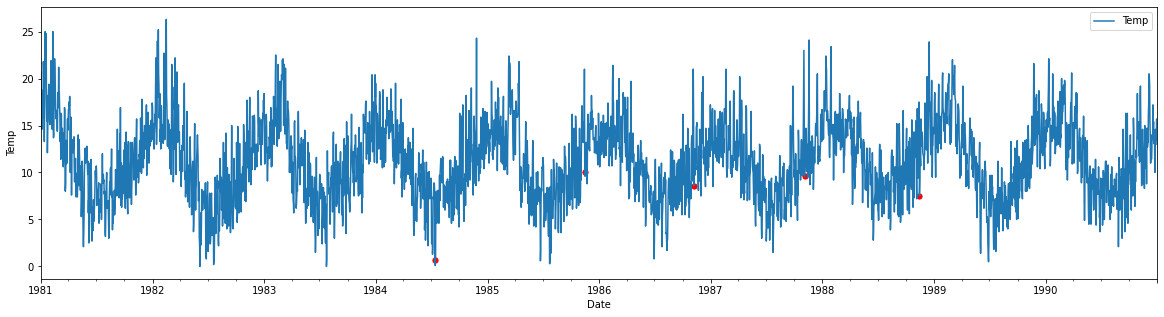

In [9]:
plot_anomalies(ts, anomalies);